In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict


c:\Users\Varun\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

In [3]:

from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi), ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. France is a semi-presidential republic. Its capital, largest city and main cultural and economic centre is Paris. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its 

In [4]:
from langchain.agents import Tool


tool_search = Tool(
    name = "search",
    func=serper.run,
    description="Useful for when you need more information from an online search"
)


In [6]:
tool_search.invoke("What is the population of India?")

"India 2025 population is estimated at 1,463,865,525 people at mid-year. India population is equivalent to 17.78% of the total world population. India ranks ... In 2023 India's population stood at slightly over 1.428 billion, edging past China's population of 1.425 billion people. World Population ; India, 1,419,316,933 ; China, 1,407,181,209 ; United States, 342,034,432 ; Indonesia, 283,587,097 ; Pakistan, 257,047,044. Total current population for India in 2025 is 1,454,606,724, a 0.89% increase from 2024. Total population for India in 2024 was 1,441,719,852, a 0.25% increase ... India is a country in Asia. The population in India was 1,438,069,596 in 2023. The nominal GDP per capita in India was $2,480.79 in 2023. The Gini index in ... It has a population of nearly 1464 million, making it the 1st largest country in the world. Its capital is New Delhi. As of 1 January 2025, the population of India was estimated to be 1,461,898,454 people. This is an increase of 1.26 % (18,176,460 peop

In [5]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})
    

In [6]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, Varun! This is a test notification from LangGraph.")

In [7]:
tools = [tool_search, tool_push]

In [8]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [13]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [15]:
# This is different:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# Step 3: Create a Node

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    messages = [response]
    new_state = state(messages=messages)
    # return {"messages": [llm_with_tools.invoke(state["messages"])]}
    return new_state

graph_builder.add_node("chatbot_node_test", chatbot)
graph_builder.add_node("tools_node_test", ToolNode(tools=tools))

In [21]:
# Step 4: Create Edges


graph_builder.add_conditional_edges( "chatbot_node_test", tools_condition, "tools_node_test")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools_node_test", "chatbot_node_test")
graph_builder.add_edge(START, "chatbot_node_test")

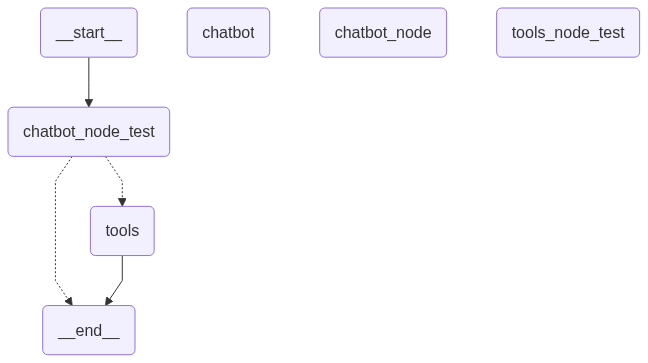

In [22]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [26]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\Varun\AppData\Local\Programs\Python\Python313\Lib\site-packages\gradio\queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    )
    ^
  File "c:\Users\Varun\AppData\Local\Programs\Python\Python313\Lib\site-packages\gradio\route_utils.py", line 350, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<11 lines>...
    )
    ^
  File "c:\Users\Varun\AppData\Local\Programs\Python\Python313\Lib\site-packages\gradio\blocks.py", line 2239, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^
  File "c:\Users\Varun\AppData\Local\Programs\Python\Python313\Lib\site-packages\gradio\blocks.py", line 1744, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^

## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

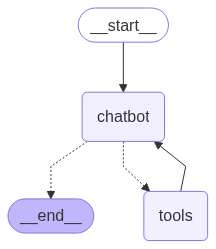

In [11]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content="My name is Varun, I'm 30 years old", additional_kwargs={}, response_metadata={}, id='7694f196-3180-4b0c-a3ce-baa346306573')]}
{'messages': [HumanMessage(content="My name is Varun, I'm 30 years old", additional_kwargs={}, response_metadata={}, id='7694f196-3180-4b0c-a3ce-baa346306573'), AIMessage(content='Nice to meet you, Varun! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 99, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bzg9DjIVEcdmsubGKTd5tg3meRX08', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3fe43c49-7215-44c9-9f30-34e58de9277f-0', usage_meta

In [ ]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content="My name is Varun, I'm 30 years old", additional_kwargs={}, response_metadata={}, id='7694f196-3180-4b0c-a3ce-baa346306573'), AIMessage(content='Nice to meet you, Varun! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 99, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bzg9DjIVEcdmsubGKTd5tg3meRX08', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3fe43c49-7215-44c9-9f30-34e58de9277f-0', usage_metadata={'input_tokens': 99, 'output_tokens': 16, 'total_tokens': 115, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detai

In [14]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content="My name is Varun, I'm 30 years old", additional_kwargs={}, response_metadata={}, id='7694f196-3180-4b0c-a3ce-baa346306573'), AIMessage(content='Nice to meet you, Varun! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 99, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bzg9DjIVEcdmsubGKTd5tg3meRX08', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3fe43c49-7215-44c9-9f30-34e58de9277f-0', usage_metadata={'input_tokens': 99, 'output_tokens': 16, 'total_tokens': 115, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_deta

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [17]:

import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path,check_same_thread=False)
sql_memory=SqliteSaver(conn)

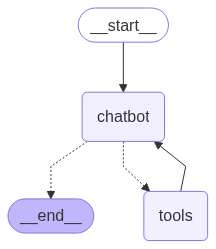

In [18]:
# Steps 1 and 2
graph_builder = StateGraph(State)

# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='d6144090-9963-438c-b21b-3fb4f06edbc0'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 90, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BInN7JUnEYNTQqokCF3eihp5oKP0V', 'finish_reason': 'stop', 'logprobs': None}, id='run-4b488710-73ac-435e-a944-913a0c812d08-0', usage_metadata={'input_tokens': 90, 'output_tokens': 11, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content="what's my name", additional_kwargs